Keras와 Music21을 활용한 LSTM방식의 Music Generator
====

In [1]:
import glob 
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from music21 import converter, instrument, note, chord, midi, stream #Python음악 툴킷

Using TensorFlow backend.


### Preprocessing
먼저 노래의 데이터를 로드합니다. 이를 위해 MIDI 파일들을 살펴보고. 각각의 음을 비교합니다. 만약 그 요소가 화음이라면, 그것은 화음의 숫자 표현으로 변환됩나다. 이 단계가 끝나면 문자열 형태로 나타나는 모든 노트/코드와  상응하는 단어를 가집니다.

In [2]:
notes = []
track = 0

for i, file in enumerate(glob.glob("Music/Etudes, Opus 10/*.mid")):
    midi = converter.parse(file)
    midi = midi[track]
    notes_to_parse = None
        
    #1차 학습 데이터: Etudes, Opus 10의 3곡 (연습곡 Op. 10, 1번, 연습곡 Op. 10, 5번(흑건), 연습곡 Op. 10, 12번(혁명 에튀드))
    #2차 학습 데이터: Piano Sonata in D major, Hoboken XVI:33의 3곡 ()
    notes_to_parse = midi.flat.notes
    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            #코드를 숫자로 표시
            notes.append('.'.join(str(n) for n in element.normalOrder))
    print("Song {} Loaded".format(i+1))
                
print("DONE LOADING SONGS")    
#모든 피치 이름 가져오기
pitches = sorted(set(item for item in notes))

vocab_length = len(pitches)  
number_notes = len(notes)
print(vocab_length)
print(notes)

Song 1 Loaded
Song 2 Loaded
Song 3 Loaded
DONE LOADING SONGS
119
['E4', 'C4', 'G4', 'C5', 'E5', 'C5', 'G5', 'C6', 'E6', 'C6', 'G6', 'C7', 'E7', 'C7', 'G6', 'C6', 'E6', 'C6', 'G5', 'C5', 'E5', 'C5', 'G4', 'C4', 'E4', 'C4', 'F4', 'C4', 'A4', 'C5', 'F5', 'C5', 'A5', 'C6', 'F6', 'C6', 'A6', 'C7', 'E7', 'C7', 'A6', 'C6', 'E6', 'C6', 'A5', 'C5', 'E5', 'C5', 'A4', 'C4', 'D4', 'C4', 'D4', 'B3', 'G4', 'B4', 'D5', 'B4', 'G5', 'B5', 'D6', 'B5', 'G6', 'A6', 'D7', 'A6', 'F#6', 'C6', 'D6', 'A5', 'F#5', 'C5', 'D5', 'A4', 'F#4', 'C4', 'D4', 'D4', 'C4', 'F4', 'G#4', 'D5', 'C5', 'F5', 'G#5', 'D6', 'C6', 'F6', 'G#6', 'D7', 'G6', 'F6', 'B5', 'D6', 'G5', 'F5', 'B4', 'D5', 'G4', 'F4', 'B3', 'E-4', 'E4', 'C4', 'G4', 'C5', 'E5', 'C5', 'G5', 'C6', 'E6', 'C6', 'G6', 'C7', 'E7', 'C7', 'G6', 'C6', 'E6', 'C6', 'G5', 'C5', 'E5', 'C5', 'G4', 'C4', 'E4', 'C4', 'F4', 'C4', 'F4', 'C5', 'F5', 'C5', 'F5', 'C6', 'F6', 'C6', 'F6', 'C7', 'E7', 'C7', 'F#6', 'C6', 'E6', 'C6', 'F#5', 'C5', 'E5', 'C5', 'F#4', 'C4', 'E4', 'C4', 

이 노트들을 우리의 LSTM에 사용할 수 있는 형태로 변환한다. 10개의 노트를 그룹으로 묶어서 다음 노트를 예측할 수 있는 시퀀스를 구성.

In [3]:
#각 노트에 대해 one-hot encoding을 사용하고 시퀀스 배열을 작성.
#우선 가능한 각 노트에 인덱스 할당.
note_dict = dict()
for i, note in enumerate(pitches):
    note_dict[note] = i
#print(note_dict)

# 각 음을 가져와 음의 위치에 1이 있는 numpy 배열로 인코딩.
sequence_length = 50
num_training = number_notes - sequence_length

input_notes = np.zeros((num_training, sequence_length, vocab_length))
output_notes = np.zeros((num_training, vocab_length))

for i in range(0, num_training):
    input_sequence = notes[i: i+sequence_length]
    output_note = notes[i+sequence_length]
    for j, note in enumerate(input_sequence):
        input_notes[i][j][note_dict[note]] = 1
    output_notes[i][note_dict[output_note]] = 1

In [ ]:
model = load_model('train_data/chopin_data.h5') #이전에 학습한 학습 데이터 로드. 처음이라면 이 코드를 주석처리하고 아래 코드부터 수행
#model = Sequential()
#model.add(LSTM(128, return_sequences=True, input_shape=(sequence_length, vocab_length)))
#model.add(Dropout(0.2))
#model.add(LSTM(128, return_sequences=False))
#model.add(Dropout(0.2))
#model.add(Dense(vocab_length))
#model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

history = model.fit(input_notes, output_notes, batch_size=128, nb_epoch=1)

print("Learning Finish!")
model.save('train_data/chopin_data.h5')
#model.save('train_data/haydn_data.h5')
#model.save('train_data/jazz_data.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


#### 모델 결과 시각화
epoch만큼의 결과를 볼 수 있습니다.

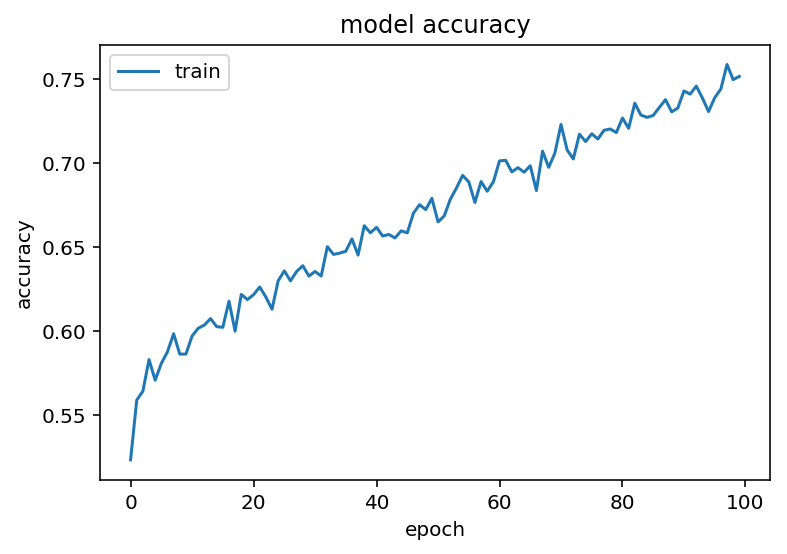

In [5]:
#학습 정확도 요약
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

### 새 음악 만들기

In [6]:
#거꾸로 된 딕셔너리 생성
backward_dict = dict()
for note in note_dict.keys():
    index = note_dict[note]
    backward_dict[index] = note

n = np.random.randint(0, len(input_notes)-1)
sequence = input_notes[n]
start_sequence = sequence.reshape(1, sequence_length, vocab_length)
output = []

#200개 노트의 곡 생성
for i in range(0, 200):
    newNote = model.predict(start_sequence, verbose=0)
    # Get the position with the highest probability
    index = np.argmax(newNote)
    encoded_note = np.zeros((vocab_length))
    encoded_note[index] = 1
    output.append(encoded_note)
    sequence = start_sequence[0][1:]
    start_sequence = np.concatenate((sequence, encoded_note.reshape(1, vocab_length)))
    start_sequence = start_sequence.reshape(1, sequence_length, vocab_length)
    
#문자열 형태로 출력
for element in output:
    print(element)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

### MIDI파일로 변환

In [7]:
from music21 import converter, instrument, note, chord, midi, stream #혹시모를 오류를 방지해 다시 로드

finalNotes = [] 
for element in output:
    index = list(element).index(1)
    finalNotes.append(backward_dict[index])
    
offset = 0
output_notes = []
    
for pattern in finalNotes:
    #패턴이 코드일 경우
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    #패턴이 노트일 경우
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)

    # 노트가 쌓이지 않도록 간격 처리
    offset += 1

midi_stream = stream.Stream(output_notes)

midi_stream.write('midi', fp='test_output.mid')

'test_output.mid'

1차 결과
----
- Epoch 300이상부터 accuracy가 .97~.98사이에 머물러 있음(Overfitting 의심)
- Midi파일에서 코드 없이 트릴의 연속으로 만들어짐
- 쇼팽의 연습곡들이 트릴이 많고 코드가 적기 떄문에 오버피팅이 쉽고 한가지 패턴만 보이는 것 같다.

#### 수정하기
- 상대적으로 코드와 트릴이 섞인 하이든의 곡으로 변경(Piano Sonata in D major, Hoboken XVI:33)

2차 결과
----
- Epoch 300정도에서 가장 좋은 결과를 보여줌
- 그러나 그 이후부터는 동일한 양상을 보여줌

#### 수정하기
- 상대적으로 복잡하고 다양성이 높은 재즈 음악의 학습 시도

3차 결과
----
- Midi파일 생성 방식이 정해진 간격으로만 생성되기 때문에 재즈와는 어울리지 않음
- Midi파일 생성 방식을 수정하거나 노트끼리의 간격도 컴퓨터가 정하게 하면 좀 더 좋은 결과물이 나올 것 같다